# CP255: Using Pandana to Measure Multi-Modal Accessibility with Automobile, Pedestrian, and Transit Networks

Created by Sam Blanchard (sablanchard@berkeley.edu) 11/7/2016

This script demonstrates the basic functionality of Pandana (Pandas Network Analysis) including: acquisition of OpenStreetMap (OSM) street network data and nearest neighbor and cumulative accessibility queries on auto, pedestrian, and transit Pandana networks.

In [2]:
import pandana as pdna
# from pandana.loaders import osm
import pandas as pd
from ipywidgets import FloatSlider, interact
from IPython.core.display import display
from urbansim.utils import misc
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [3]:
pdna.__version__

'0.4.0'

In [5]:
def plot_nodes(x_data=None,y_data=None,node_size=15,node_color='black',color_map=None,edge_color=None):
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, s=node_size, c=node_color,
                   alpha=1, edgecolor=edge_color,cmap=color_map,
                   zorder=3)
    plt.show()
    return fig, ax

Pandana is a Python and C++ network analysis tool that can compute network accessibility using: 1) shortest path queries between ODs for any number of nodes within a search radius; and 2) aggregation queries using a cumulative opportunities accessibility method.  

A variety of statistics and can be used including sum, average, standard deviation, and count along with a number of distance decay functions such as linear and exponential. Pandana requires: 1) a set of OD node coordinates (e.g. based on addresses or Census block centroids) for which accessibility will be computed between and can include variables of interest such as socioeconomic data or business establishments that can be queried or aggregated; and 2) a network of nodes and weighted edges used for network routing. The OD nodes are connected to the nearest node in the graph network.

Pandana calculates the shortest path (e.g. lowest cost path) between ODs over a hierarchical network using the contraction hierarchies algorithm. Contraction hierarchies allows for rapid network calculations over large geographic extents and is an improvement upon the more traditional Dijkstra's shortest path algorithm. 

Pandana can be acquired as a open source library here: https://github.com/UDST/pandana

For more detailed information on Pandana see:

Fletcher Foti and Paul Waddell. 2014. "A Generalized Computational Framework for Accessibility: From the Pedestrian to the Metropolitan Scale"

Set data path

In [6]:
data_path = 'data/'

# #1 Pandana networks

## Nodes

Pandana nodes consist of a unique "id" with spatial coordinates (latitude and longitude). Nodes are the vertices of a graph network representing street intersections.

In [7]:
nodes = pd.DataFrame({'id':[1,2,3,4],
                      'x':[-122.302578,-122.177008,-122.181374,-122.184170],
                      'y':[37.560184,37.481747,37.483689,37.484536]})

In [8]:
nodes

id           x          y
0   1 -122.302578  37.560184
1   2 -122.177008  37.481747
2   3 -122.181374  37.483689
3   4 -122.184170  37.484536

Plot the nodes on a map

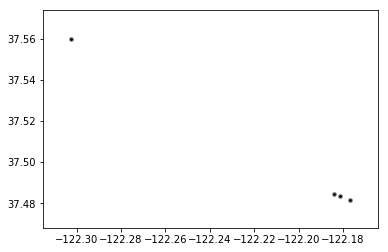

(<matplotlib.figure.Figure at 0x117773198>,
 <matplotlib.axes._subplots.AxesSubplot at 0x117773cc0>)

In [9]:
plot_nodes(x_data=nodes['x'],
           y_data=nodes['y'],
           node_size=15,
           node_color='black',
           color_map=None,
           edge_color='#999999')

## Edges

Pandana edges consist of a "from" node id and "to" node id column which is used to denote direction and an impedance column or weight column representing a friction factor for travel between the two nodes, in this case distance in meters, but this can also be travel time or a utility value. Edges are the connections between nodes representing streets and pathways.

In [10]:
edges = pd.DataFrame({'from':[1,2,3],
                      'to':[2,3,4],
                      'distance_m':[3000,6000,8000]})
edges

distance_m  from  to
0        3000     1   2
1        6000     2   3
2        8000     3   4

You can convert the edge weights to represent any unit  
for example convert distance into pedestrian travel time at 3 MPH

In [11]:
SPEED_MPH = 3
edges['travel_time_min'] = (edges['distance_m']/1609.34) / SPEED_MPH * 60
edges

distance_m  from  to  travel_time_min
0        3000     1   2        37.282364
1        6000     2   3        74.564728
2        8000     3   4        99.419638

Pandana edges can be either "one way" or "two way". Lets convert the one way edge table above to a two way edge table

In [12]:
edges = edges.append(edges.rename(inplace=False,columns={'from':'to','to':'from'})).reset_index(drop=True)
edges

distance_m  from  to  travel_time_min
0        3000     1   2        37.282364
1        6000     2   3        74.564728
2        8000     3   4        99.419638
3        3000     2   1        37.282364
4        6000     3   2        74.564728
5        8000     4   3        99.419638

# #1 Nearest neighbor query

### Download street network data: Auto network

Use Pandana to acquire the auto street network within a bounding box for Alameda County, CA from OpenStreetMap. Then remove low connectivity nodes from the graph network and save as a local hdf5 file. "drive" network type extracts auto only OSM street network components. "Two_way" denotes each edge in the network is traversable in both directions with the same weight.

Bounding box from: http://boundingbox.klokantech.com/

In [13]:
'''
%%time
h5file = 'osm_drive_2way_subset.h5'
network = pdna.loaders.osm.network_from_bbox(lat_min=37.454539, 
                                                lng_min=-122.342665, 
                                                lat_max=37.905668, 
                                                lng_max=-121.469214, 
                                                network_type='drive', 
                                                two_way=True)
lcn = network.low_connectivity_nodes(10000, 10, imp_name='distance')
network.save_hdf5(data_path+h5file, rm_nodes=lcn)
print 'OSM data save completed:', data_path, h5file
'''

"\n%%time\nh5file = 'osm_drive_2way_subset.h5'\nnetwork = pdna.loaders.osm.network_from_bbox(lat_min=37.454539, \n                                                lng_min=-122.342665, \n                                                lat_max=37.905668, \n                                                lng_max=-121.469214, \n                                                network_type='drive', \n                                                two_way=True)\nlcn = network.low_connectivity_nodes(10000, 10, imp_name='distance')\nnetwork.save_hdf5(data_path+h5file, rm_nodes=lcn)\nprint 'OSM data save completed:', data_path, h5file\n"

Load previously generated auto network

In [14]:
%%time
h5file = 'osm_drive_2way_subset.h5'
osm_drive_nodes = pd.HDFStore(data_path+h5file).nodes
osm_drive_edges = pd.HDFStore(data_path+h5file).edges

CPU times: user 42.7 ms, sys: 18.5 ms, total: 61.2 ms
Wall time: 88.7 ms


## Inspect the network

### Nodes

In [16]:
print('Total number of nodes:', len(osm_drive_nodes))
osm_drive_nodes.head()

Total number of nodes: 94981


x          y
b'id'                          
281266   -122.302578  37.560184
26028129 -122.177008  37.481747
26028133 -122.181374  37.483689
26029745 -122.184170  37.484536
26029880 -122.284735  37.541234

### Edges

In [17]:
print('Total number of edges:', len(osm_drive_edges))
osm_drive_edges.head()

Total number of edges: 135169


from         to     distance
281266   65358141     281266   65358141   321.454500
         702274215    281266  702274215  1327.931491
26028129 26028133   26028129   26028133   441.690295
         65385638   26028129   65385638   236.607166
26028133 26029745   26028133   26029745   264.163233

## Initialize a Pandana network

Initialize the Pandana network object to be used in the nearest neighbor query

In [19]:
%%time
drive_net = pdna.Network(osm_drive_nodes["x"], 
                   osm_drive_nodes["y"], 
                   osm_drive_edges["from"], 
                   osm_drive_edges["to"],
                   osm_drive_edges[["distance"]],twoway=True)
print('Network initialized')

Network initialized
CPU times: user 8.26 s, sys: 56.4 ms, total: 8.32 s
Wall time: 8.33 s


## Load input data

### POI data

OSHPD Hospitals 2012 from: https://www.oshpd.ca.gov/documents/HWDD/GIS/HealthcareFacilities201210.zip  
CPAD Parks 2016 from: http://atlas.ca.gov/casil/planning/Land_Ownership/GreenInfoNetworkProject/CPAD-2016a-June2016/CPAD_2016a.zip

Shapefiles have been post-processed by converting each shapefile to a csv and adding explicit centroid coordinates columns.

Read data into a Pandas dataframe and subset for Alameda county and other attributes.

In [20]:
hospitals = pd.read_csv(data_path+'oshpd_points.csv')
hospitals = hospitals[hospitals['COUNTY'] == 'Alameda']
hospitals = hospitals[hospitals['TYPE'] == 'Hospital']
hospitals = hospitals[hospitals['FAC_STATUS'] == 'Open']
print('Loaded', str(len(hospitals)), 'hospitals.')

Loaded 24 hospitals.


In [21]:
hospitals.head()

X          Y  OBJECTID   OSHPD_ID LICENSE_NO  LICENSEID  \
14 -122.231187  37.799165      7462  106010846  140000046    53955.0   
15 -122.120557  37.707885      7463  106010811  140000046    53955.0   
16 -122.257997  37.824315      7464  106010856  140000052    54767.0   
18 -122.093367  37.625925      7466  106010858  140000053    54766.0   
19 -121.974817  37.550545      7467  106014132  140000053    54766.0   

    ADDRESSID  FACILITYID  ENTITYID  PERM_ID    ...      FDD HSA SPA RUCA MA  \
14         15           8      66.0    11288    ...      CEN   5   0    0  1   
15         11           6      66.0    11268    ...      CEN   5   0    0  1   
16         17           9    1453.0    11296    ...      CEN   5   0    0  1   
18         19          10    1453.0    11295    ...      CEN   5   0    0  1   
19         44          23    1453.0    14509    ...      CEN   5   0    0  1   

   UA  CAH  DSH  FQHC  FQHC_LOOK  
14  1    0    1     0          0  
15  1    0    0     0          0  
16  1    0    0     0          0  
18  1    0    0     0          0  
19  1    0    0     0          0  

[5 rows x 61 columns]

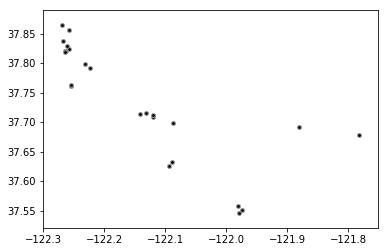

(<matplotlib.figure.Figure at 0x1a250c1978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a250c1cf8>)

In [22]:
plot_nodes(x_data=hospitals['X'],
           y_data=hospitals['Y'],
           node_size=15,
           node_color='black',
           color_map=None,
           edge_color='#999999')

In [24]:
parks = pd.read_csv(data_path+'cpad_points.csv')
parks = parks[parks['COUNTY'] == 'Alameda']
parks = parks[parks['ACCESS_TYP'] == 'Open Access']
print('Loaded', str(len(parks)), 'parks.')

Loaded 556 parks.


In [25]:
parks.head()

WKT   ACCESS_TYP  UNIT_ID  \
23   POINT (-121.91827114499223 37.479020716144205)  Open Access    12981   
25    POINT (-121.8974876973582 37.649989485289161)  Open Access    44185   
70   POINT (-122.03929437429197 37.549850592549276)  Open Access    23667   
108  POINT (-121.72230367643789 37.527171205806965)  Open Access    29544   
127  POINT (-122.14244375202195 37.741189943450522)  Open Access    13404   

                      UNIT_NAME  SUID_NMA  AGNCY_ID  \
23                 Booster Park     16273      1113   
25              Fawn Hills Park     18854      1257   
70         MacGregor Playfields     21628      1221   
108  Ohlone Regional Wilderness     10826      2032   
127        Dunsmuir Estate Park     18309      1228   

                          AGNCY_NAME         AGNCY_LEV  \
23                  Fremont, City of              City   
25               Pleasanton, City of              City   
70                   Newark, City of              City   
108  East Bay Regional Park District  Special District   
127                 Oakland, City of              City   

                  AGNCY_TYP  \
23              City Agency   
25              City Agency   
70              City Agency   
108  Regional Park District   
127             City Agency   

                                             AGNCY_WEB    ...     MNG_AG_ID  \
23                    http://www.fremont.gov/316/Parks    ...          1113   
25                  http://www.cityofpleasantonca.gov/    ...          1257   
70   http://www.ci.newark.ca.us/departments/recreat...    ...          1221   
108                            http://www.ebparks.org/    ...          2032   
127  http://www2.oaklandnet.com/Government/o/opr/in...    ...          1228   

                          MNG_AGENCY                             PARK_URL  \
23                  Fremont, City of                                  NaN   
25               Pleasanton, City of                                  NaN   
70                   Newark, City of                                  NaN   
108  East Bay Regional Park District  http://www.ebparks.org/parks/ohlone   
127                 Oakland, City of                                  NaN   

      COUNTY     ACRES              LABEL_NAME                   DES_TP  \
23   Alameda     8.178            Booster Park               Local Park   
25   Alameda     4.875         Fawn Hills Park               Local Park   
70   Alameda     7.401    MacGregor Playfields    Local Recreation Area   
108  Alameda  5442.916  Ohlone Reg. Wilderness  Local Conservation Area   
127  Alameda    25.146    Dunsmuir Estate Park               Local Park   

    GAP_STS      XCOORD     YCOORD  
23      4.0 -121.918271  37.479021  
25      4.0 -121.897488  37.649989  
70      4.0 -122.039294  37.549851  
108     2.0 -121.722304  37.527171  
127     4.0 -122.142444  37.741190  

[5 rows x 21 columns]

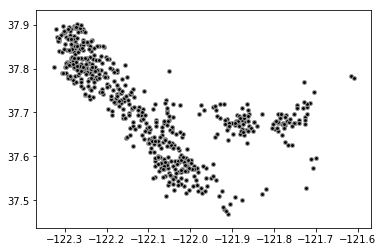

(<matplotlib.figure.Figure at 0x1a25081908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1121ec160>)

In [26]:
plot_nodes(x_data=parks['XCOORD'],
           y_data=parks['YCOORD'],
           node_size=15,
           node_color='black',
           color_map=None,
           edge_color='#999999')

## Calculate nearest neighbor

For each node on the network calculate the distance to the nearest 2 hospital and 2 park features within a 10 km network search radius.

Initialize the POIs on the network for two types of POIs with a max query distance of 10 km meters for the nearest 2 POIs. Then set the POIs on the network.

In [30]:
%%time
drive_net.set_pois(maxdist=10000,maxitems=2,category="parks", x_col=parks['XCOORD'], y_col=parks['YCOORD'])
drive_net.set_pois(maxdist=10000,maxitems=2,category="hospitals", x_col=hospitals['X'], y_col=hospitals['Y'])

CPU times: user 31 ms, sys: 4.31 ms, total: 35.3 ms
Wall time: 35.4 ms


Calculate the distance between each network node and the nearest 2 POIs for each category within a 10 km network radius.

In [31]:
%%time
nearest_parks = drive_net.nearest_pois(distance=10000, category="parks", num_pois=2,max_distance=0)
nearest_hospitals = drive_net.nearest_pois(distance=10000, category="hospitals", num_pois=2,max_distance=0)

CPU times: user 3.2 s, sys: 28.5 ms, total: 3.23 s
Wall time: 3.23 s


## View results

Inspect results: Network node id and network distance to first and second closest hospital within 10 km

In [32]:
nearest_hospitals[nearest_hospitals[1]>0].head()

1            2
b'id'                             
26819598  7406.579102  9121.921875
29891370  4553.059082  9030.510742
29891391  6339.383789  9458.651367
29891439  1663.937012  1744.010010
30029450  5118.064941  8369.219727

## View results on a map

### Oakland: Distance to nearest hospital within 10 km

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a217ec7f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1176aeb00>)

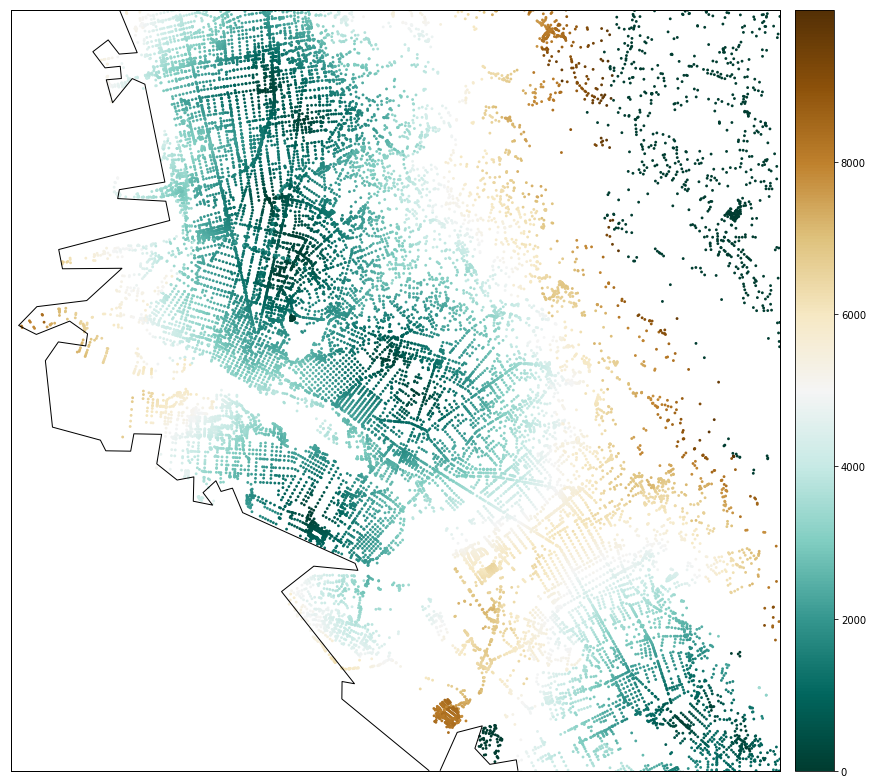

In [33]:
bbox = (37.6991981,-122.3426649,37.8847249,-122.1149234) #oakland
drive_net.plot(nearest_hospitals[1], 
         bbox=bbox,
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'BrBG_r','s':8,'edgecolor':'none'})

### Alameda County: Distance to nearest hospital within 10 km

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a2191efd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a23d93dd8>)

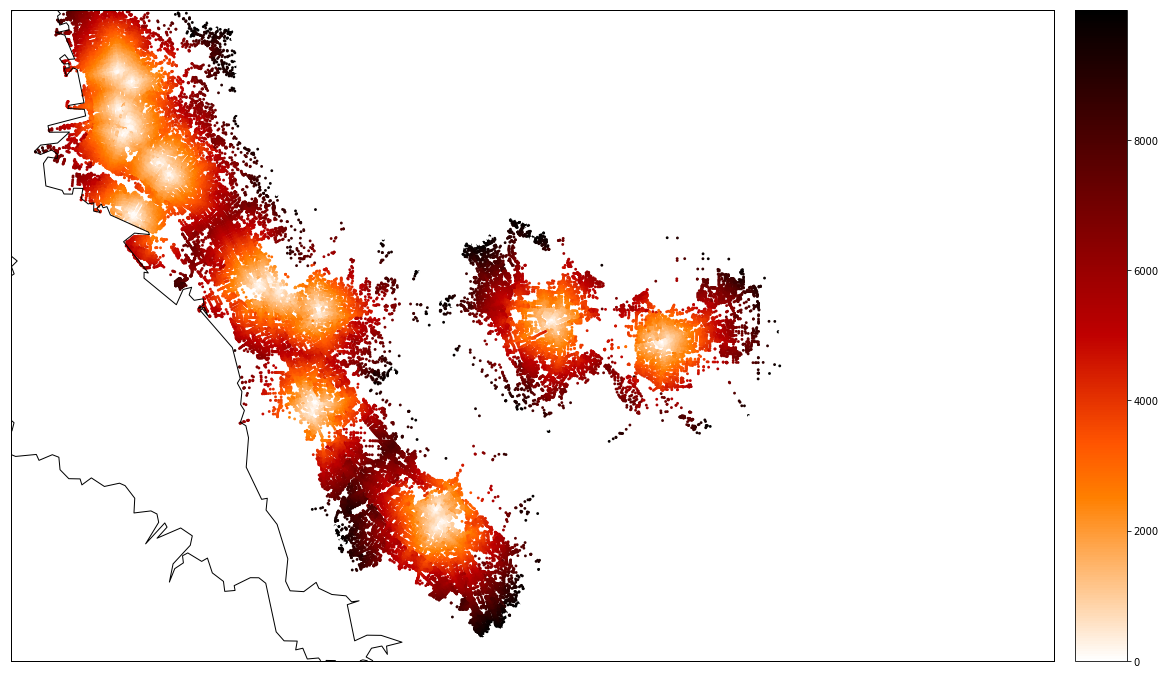

In [34]:
drive_net.plot(nearest_hospitals[1], 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

Interactively change the distance threshold

In [35]:
def net_query(distance):
    nearest_hospitals = drive_net.nearest_pois(distance=distance, 
                                         category="hospitals", 
                                         num_pois=2,
                                         max_distance=0)
    drive_net.plot(nearest_hospitals[1], 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

In [36]:
v = interact(net_query,distance=FloatSlider(min=0, max=10000, step=1000,continuous_update=False))
display(v)

A Jupyter Widget

<function __main__.net_query>

### Alameda County: Distance to nearest park within 10 km

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a2478a6d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a25471cf8>)

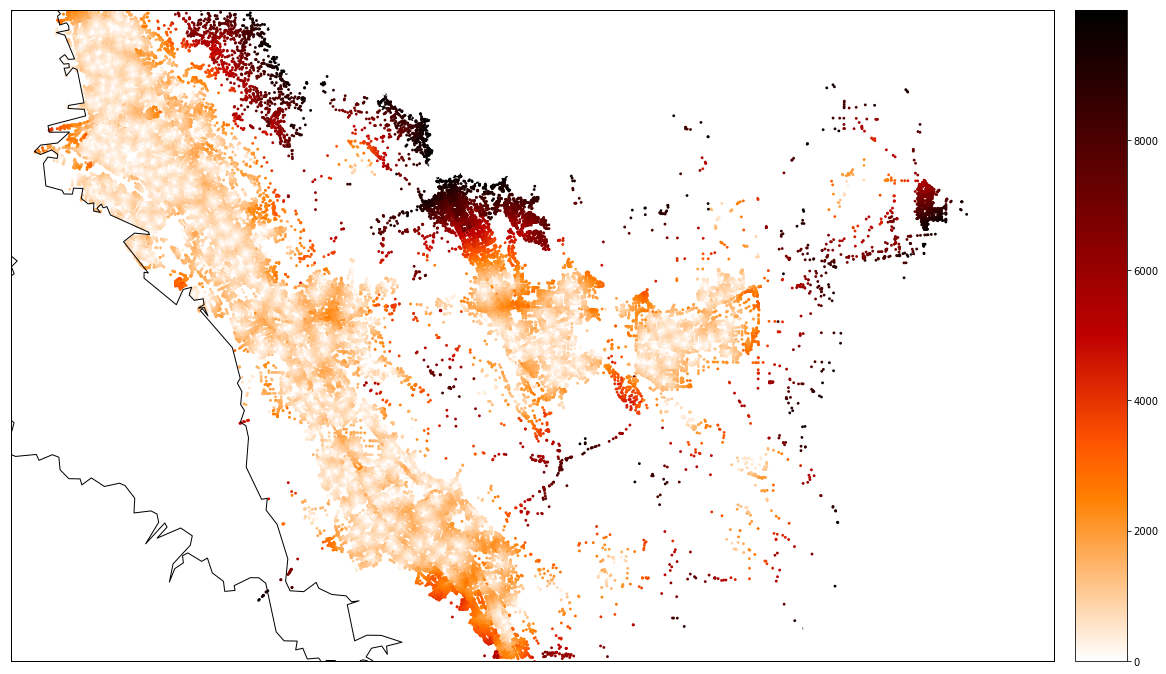

In [37]:
drive_net.plot(nearest_parks[1], 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

# #3 Cumulative opportunities accessibility query

## Load input variable and network data

Data includes Census blocks for Alameda County with block level synthesized job and household data (as agents)

In [38]:
%%time
blocks = pd.read_csv(data_path+'blocks_subset.csv', index_col='block_id')
jobs = pd.read_csv(data_path+'jobs_subset.csv', index_col='job_id')
households = pd.read_csv(data_path+'households_subset.csv', index_col='block_id')
print('Loaded',str(len(blocks)),'blocks',str(len(jobs)),'jobs',str(len(households)),'households')

Loaded 32418 blocks 922291 jobs 766484 households
CPU times: user 1.27 s, sys: 111 ms, total: 1.39 s
Wall time: 1.39 s


## Inspect the data

In [39]:
blocks.head()

x          y  residential_units  \
block_id                                                   
60133452031015 -122.034088  37.796320                  0   
60014511013346 -121.584289  37.589689                  3   
60014507013074 -121.732921  37.565688                  0   
60133451111000 -121.956067  37.755973                308   
60014371011019 -122.149724  37.654760                  1   

                non_residential_sqft  own_multifam_1940s  own_multifam_1950s  \
block_id                                                                       
60133452031015                     0                   0                   0   
60014511013346                     0                   0                   0   
60014507013074                     0                   0                   0   
60133451111000                139000                   0                   0   
60014371011019                362500                   0                   0   

                own_multifam_1960s  own_multifam_1970s  own_multifam_1980s  \
block_id                                                                     
60133452031015                   0                   0                   0   
60014511013346                   0                   0                   0   
60014507013074                   0                   0                   0   
60133451111000                   0                   0                   0   
60014371011019                   0                   0                   0   

                own_multifam_1990s     ...      rnt_singlfam_1950s  \
block_id                               ...                           
60133452031015                   0     ...                       0   
60014511013346                   0     ...                       0   
60014507013074                   0     ...                       0   
60133451111000                   0     ...                       0   
60014371011019                   0     ...                       0   

                rnt_singlfam_1960s  rnt_singlfam_1970s  rnt_singlfam_1980s  \
block_id                                                                     
60133452031015                   0                   0                   0   
60014511013346                   0                   1                   0   
60014507013074                   0                   0                   0   
60133451111000                   6                   3                  30   
60014371011019                   0                   0                   0   

                rnt_singlfam_1990s  rnt_singlfam_2000s  rnt_singlfam_post2010  \
block_id                                                                        
60133452031015                   0                   0                      0   
60014511013346                   0                   1                      0   
60014507013074                   0                   0                      0   
60133451111000                   0                   0                      0   
60014371011019                   0                   1                      0   

                rnt_singlfam_pre1939  res_rents  res_values  
block_id                                                     
60133452031015                     0        0.0         0.0  
60014511013346                     0      892.0   1100001.1  
60014507013074                     0        0.0         0.0  
60133451111000                     0     2201.1    799400.0  
60014371011019                     0     1776.0    573900.0  

[5 rows x 42 columns]

In [40]:
jobs.head()

block_id  sector_id
job_id                           
1       60014001001007         12
2       60014001001007         12
3       60014001001007         12
4       60014001001007         12
5       60014001001007         12

In [41]:
households.head()

household_id      serialno  persons  cars    income  \
block_id                                                              
60816100001000             2  2.013000e+12      1.0   2.0  100000.0   
60014251041009            97  2.013001e+12      1.0   1.0   65000.0   
60014515033001           126  2.009000e+12      1.0   1.0   19200.0   
60014419262000           142  2.013001e+12      1.0   1.0   14000.0   
60014305002004           257  2.009001e+12      1.0   1.0    6000.0   

                race_of_head  age_of_head  workers  children  tenure  \
block_id                                                               
60816100001000           1.0         43.0      1.0       0.0       1   
60014251041009           1.0         64.0      1.0       0.0       1   
60014515033001           1.0         64.0      0.0       0.0       1   
60014419262000           9.0         60.0      1.0       0.0       1   
60014305002004           1.0         93.0      0.0       0.0       1   

                recent_mover  
block_id                      
60816100001000             0  
60014251041009             0  
60014515033001             0  
60014419262000             1  
60014305002004             0

## Create accessibility variables of interest and set them on the network

Aggregate job and worker agents to the block level

In [42]:
blocks['node_id'] = drive_net.get_node_ids(blocks['x'], blocks['y'])
blocks['jobs'] = jobs.groupby(jobs.block_id).size()
blocks['workers'] = households.groupby(households.index).workers.sum()
blocks = blocks.fillna(0)

set the variables on the Pandana network

In [43]:
drive_net.set(blocks.node_id, variable = blocks.jobs, name='jobs')
drive_net.set(blocks.node_id, variable = blocks.workers, name='workers')

## Precompute the network

Precompute the distance query from 0 to 3000 m to speed up the query. Note: This is memory intensive.

In [44]:
%%time
drive_net.precompute(3000)

CPU times: user 11.1 s, sys: 308 ms, total: 11.5 s
Wall time: 11.4 s


## Calculate cumulative accessibility

For each block, calculate the cumulative number of total jobs accessible for blocks within a 1, 2, 3 km network radius.

In [45]:
%%time
jobs_1000 = drive_net.aggregate(1000, 
                              type='sum', 
                              decay='linear', 
                              name = 'jobs')
jobs_2000 = drive_net.aggregate(2000, 
                              type='sum', 
                              decay='linear', 
                              name = 'jobs')
jobs_3000 = drive_net.aggregate(3000, 
                              type='sum', 
                              decay='linear', 
                              name = 'jobs')

CPU times: user 2.22 s, sys: 9.71 ms, total: 2.23 s
Wall time: 2.23 s


Do the same for the number of workers

In [46]:
%%time
workers_3000 = drive_net.aggregate(3000, 
                              type='sum', 
                              decay='linear', 
                              name = 'workers')

CPU times: user 1.2 s, sys: 4.5 ms, total: 1.2 s
Wall time: 1.2 s


## View results

Combine all results into a Pandas dataframe

In [47]:
results_drive = pd.DataFrame({'jobs_1000':misc.reindex(jobs_1000, blocks.node_id),
                              'jobs_2000':misc.reindex(jobs_2000, blocks.node_id),
                              'jobs_3000':misc.reindex(jobs_3000, blocks.node_id),
                              'workers_3000':misc.reindex(workers_3000, blocks.node_id)})
results_drive.tail()

jobs_1000    jobs_2000    jobs_3000  workers_3000
block_id                                                          
60855112001002  265.445112  1023.657699  2266.392077   5346.370356
60855046021011    0.994995   795.141473  1651.337697   1002.901462
60855044222007  303.657921  1564.166172  3014.334276   3131.150657
60855044221003  388.591625   911.991165  2207.248866   2618.078869
60855044203011    0.000000    39.209638    58.130318    100.662880

## View results on a map

### Alameda County: Total jobs within 1 km

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a2583a828>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a247ad400>)

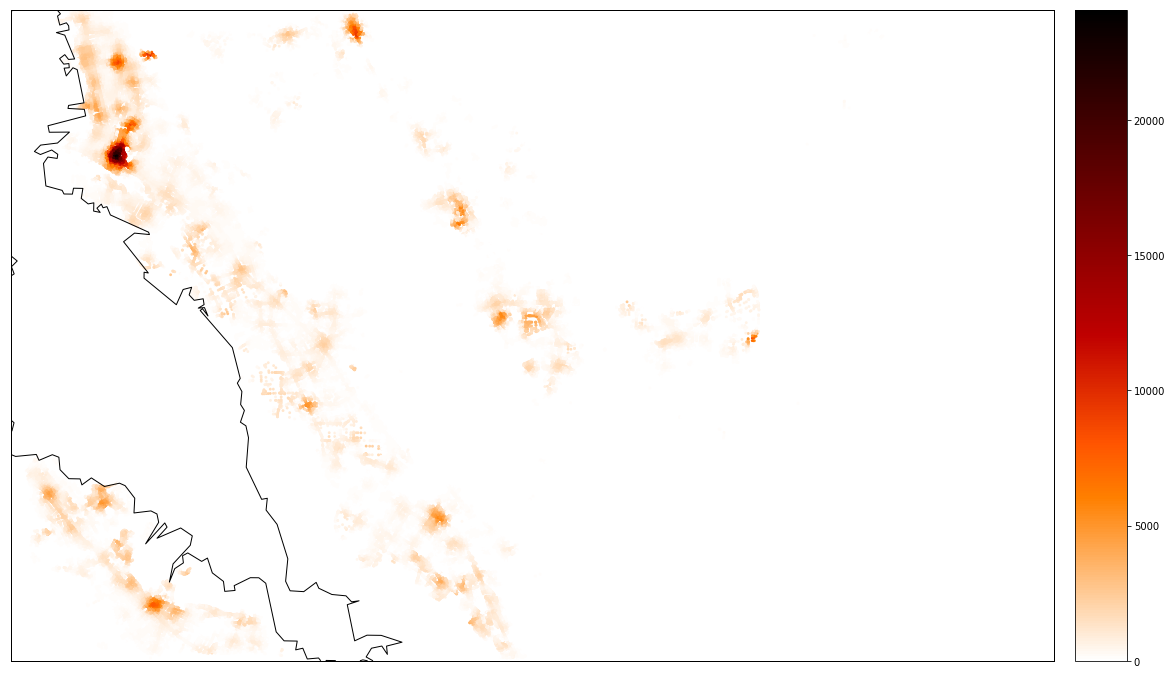

In [48]:
drive_net.plot(jobs_1000, 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

### Alameda County: Total jobs within 2 km

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a26ca68d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a25bb51d0>)

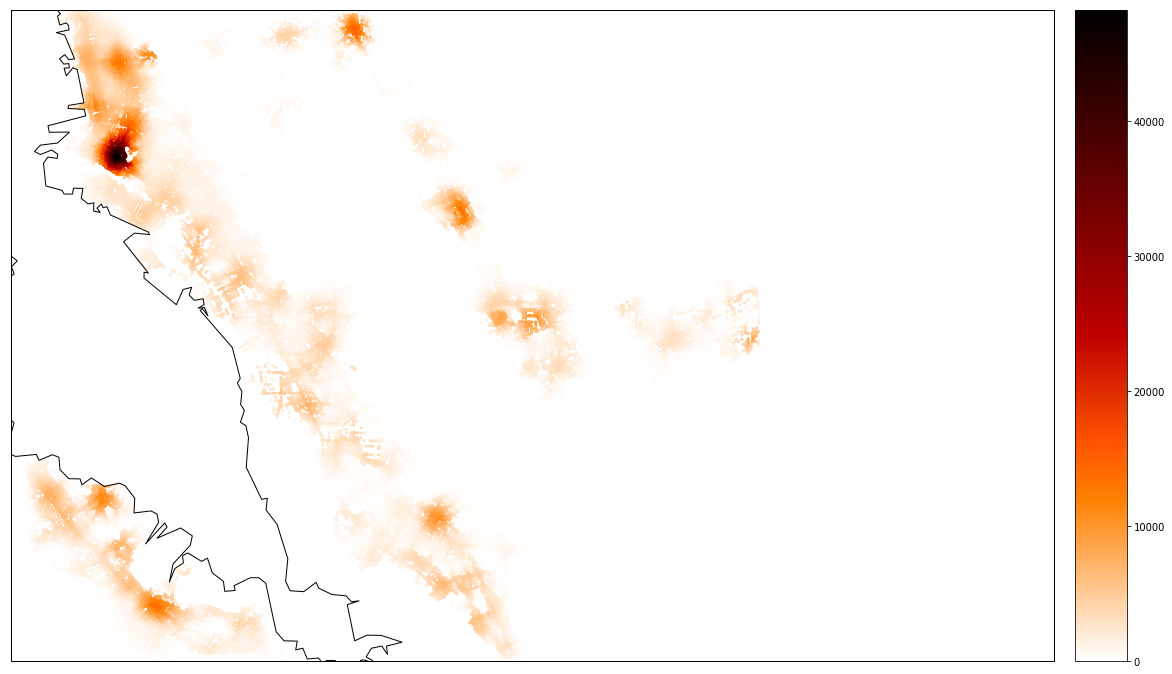

In [49]:
drive_net.plot(jobs_2000, 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

### Alameda County: Total jobs within 3 km

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a293219e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a27645278>)

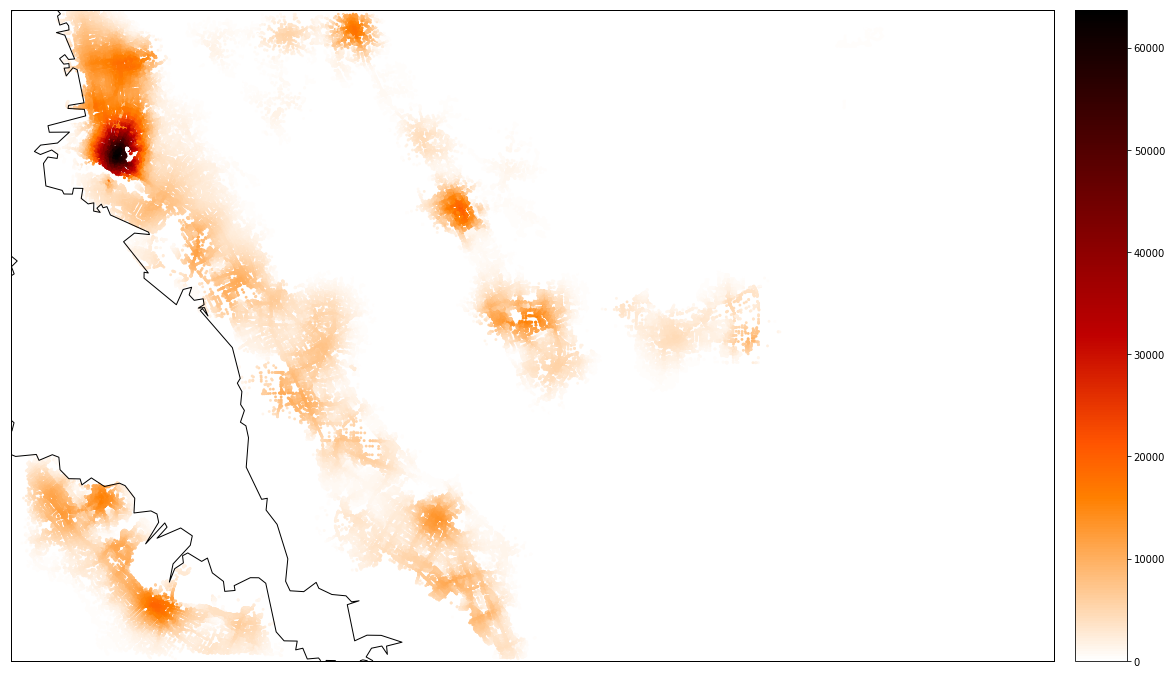

In [50]:
drive_net.plot(jobs_3000, 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

### Alameda County: Total workers within 3 km

(<mpl_toolkits.basemap.Basemap at 0x7c076ac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1178fef0>)

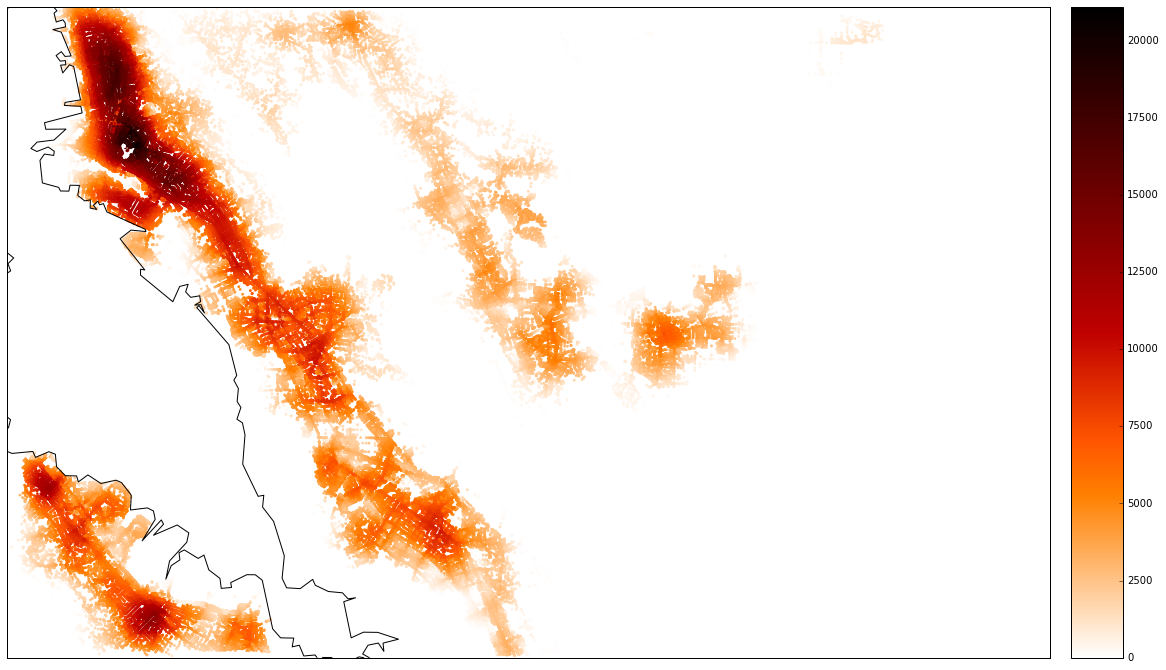

In [43]:
drive_net.plot(workers_3000, 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

# Transit+Pedestrian network

The transit+pedestrian network used here was created using UrbanAccess. UrbanAccess is a Python General Transit Feed Specification (GTFS) data acquisition, processing, and Pandana network creation tool designed to be used in tandem with Pandana for accessibility queries. UrbanAccess includes tools: 1) to connect and search GTFS data APIs; 2) validate GTFS data; 3) create individual agency or metropolitan scale transit networks; 4) compute headways; 5) penalize network impedance by transit mode.

The UrbanAccess library will soon be on UDST: https://github.com/UDST/

For more detailed information on UrbanAccess see:

Samuel D. Blanchard and Paul Waddell. Forthcoming. "UrbanAccess: A Generalized Methodology for Measuring Regional Accessibility with an Integrated Pedestrian and Transit Network" Transportation Research Record: Journal of the Transportation Research Board.

In [51]:
%%time
blocks = pd.read_csv(data_path+'blocks_subset.csv', index_col='block_id')
jobs = pd.read_csv(data_path+'jobs_subset.csv', index_col='job_id')
households = pd.read_csv(data_path+'households_subset.csv', index_col='block_id')

hdffile = 'transit_ped_network.h5'
transit_nodes = pd.HDFStore(data_path+hdffile).nodes
transit_edges = pd.HDFStore(data_path+hdffile).edges
transit_edges.drop('id', axis=1, inplace=True)

print('Loaded',str(len(blocks)),'blocks',str(len(jobs)),'jobs',str(len(households)),'households')
print('Loaded',str(len(transit_nodes)),'nodes',str(len(transit_edges)),'edges')

Loaded 32418 blocks 922291 jobs 766484 households
Loaded 114536 nodes 217767 edges
CPU times: user 1.3 s, sys: 123 ms, total: 1.43 s
Wall time: 1.43 s


The transit network represents the AM Peak scheduled network of AC Transit from 7 am to 10 am with edges weighted by travel time. Pedestrian to transit connector edges have been weighted by the average route stop headways to represent expected passenger wait time. This network has been integrated with the pedestrian network which uses a standard walking speed of 3 MPH to calculate the pedestrian travel time.

In [52]:
%%time
transit_net = pdna.Network(transit_nodes["x"], 
                           transit_nodes["y"], 
                           transit_edges["from"], 
                           transit_edges["to"],
                           transit_edges[["weight"]],twoway=False)

CPU times: user 17.5 s, sys: 90.3 ms, total: 17.6 s
Wall time: 17.6 s


In [53]:
%%time
%%capture
blocks['node_id'] = transit_net.get_node_ids(blocks['x'], blocks['y'])
blocks['jobs'] = jobs.groupby(jobs.block_id).size()
transit_net.set(blocks.node_id, variable = blocks.jobs, name='transit_jobs')

CPU times: user 86.7 ms, sys: 11.5 ms, total: 98.2 ms
Wall time: 97 ms


Run an aggregation query to calculate the total number of jobs accessible within a 20 minute travel time along the transit+pedestrian network.

In [ ]:
%%time
transit_jobs_20 = transit_net.aggregate(20, type='sum', decay='linear', name = 'transit_jobs')

In [ ]:
results_transit = pd.DataFrame({'transit_jobs_20':misc.reindex(transit_jobs_20, blocks.node_id)})
results_transit.tail()

## View results on a map

### Alameda County

### 20 min

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a3a08a198>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a3a0ccf28>)

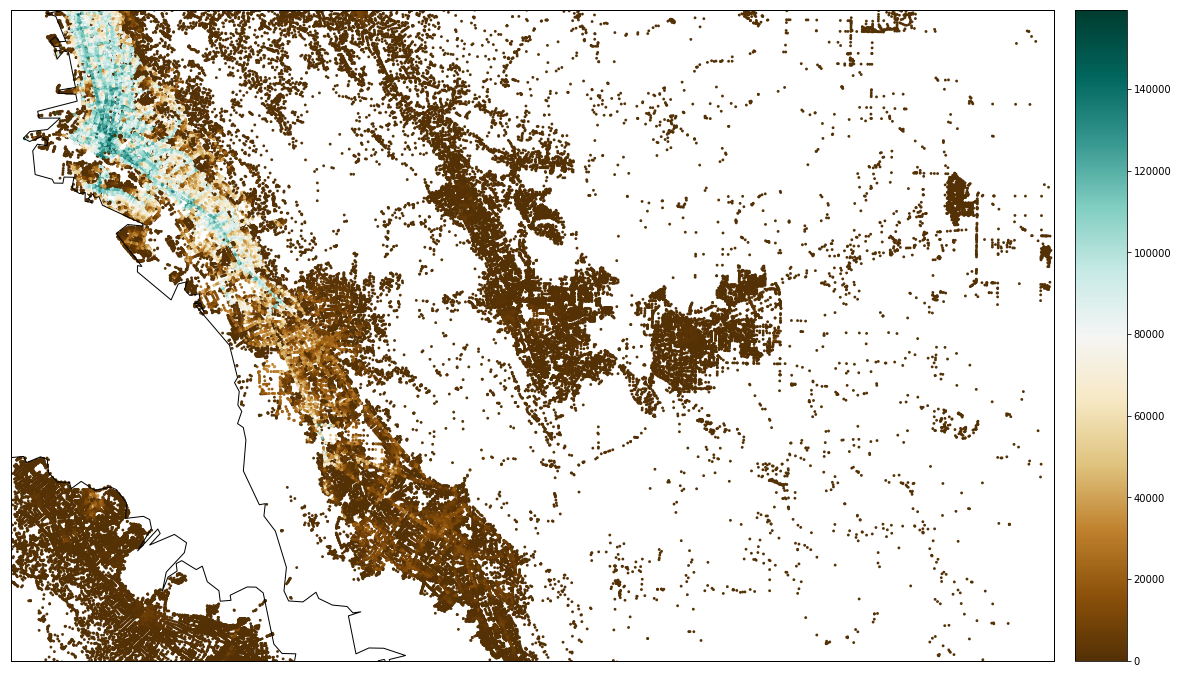

In [62]:
bbox = (37.454539,-122.342665,37.905668,-121.469214) # alameda county
transit_net.plot(transit_jobs_20, 
         bbox=bbox,
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'3310','resolution':'h'},
         plot_kwargs={'cmap':'BrBG','s':8,'edgecolor':'none'})

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a415f78d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a36f87278>)

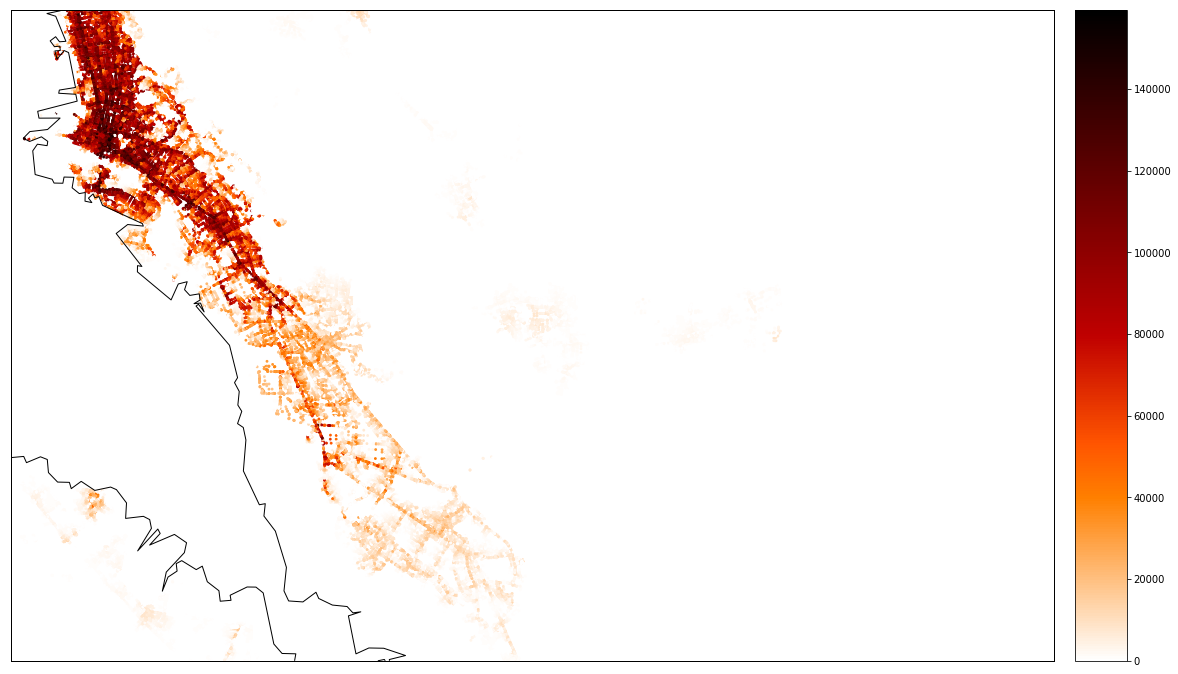

In [63]:
bbox = (37.454539,-122.342665,37.905668,-121.469214) # alameda county
transit_net.plot(transit_jobs_20, 
         bbox=bbox,
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'3310','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

### Oakland

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a43ec2908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a42011dd8>)

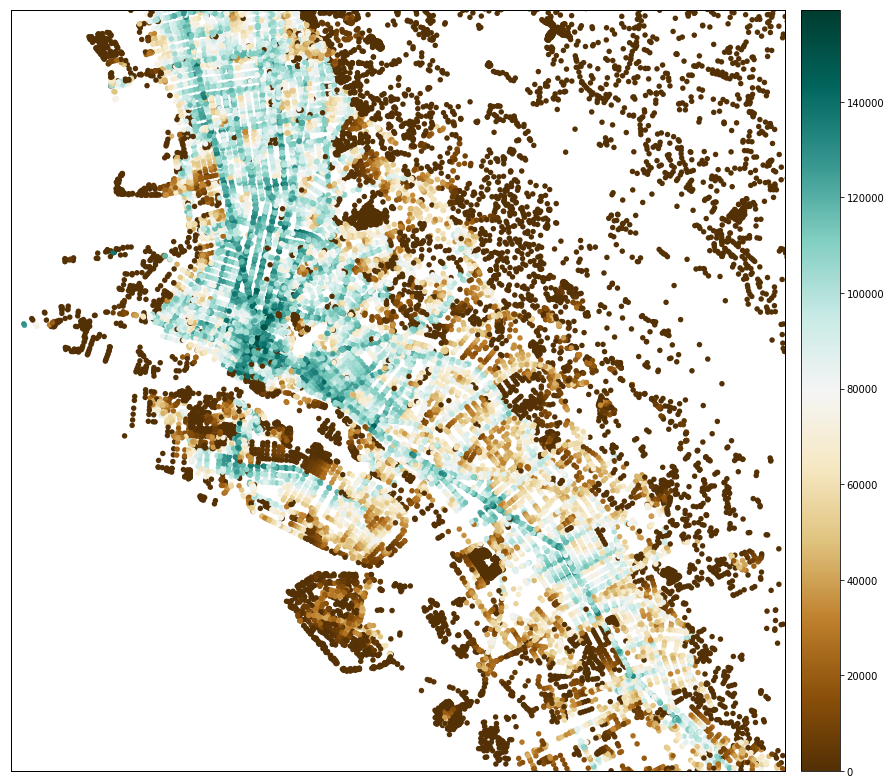

In [64]:
bbox = (37.6991981,-122.3426649,37.8847249,-122.1149234) #oakland
transit_net.plot(transit_jobs_20, 
         bbox=bbox,
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'3310','resolution':'h','area_thresh':100000000000000000},
         plot_kwargs={'cmap':'BrBG','s':30,'edgecolor':'none'})

You can combine census data with accessibility metrics in order to investigate patterns of low or high access neighborhoods and socioeconomics.

In [65]:
households.head()

household_id      serialno  persons  cars    income  \
block_id                                                              
60816100001000             2  2.013000e+12      1.0   2.0  100000.0   
60014251041009            97  2.013001e+12      1.0   1.0   65000.0   
60014515033001           126  2.009000e+12      1.0   1.0   19200.0   
60014419262000           142  2.013001e+12      1.0   1.0   14000.0   
60014305002004           257  2.009001e+12      1.0   1.0    6000.0   

                race_of_head  age_of_head  workers  children  tenure  \
block_id                                                               
60816100001000           1.0         43.0      1.0       0.0       1   
60014251041009           1.0         64.0      1.0       0.0       1   
60014515033001           1.0         64.0      0.0       0.0       1   
60014419262000           9.0         60.0      1.0       0.0       1   
60014305002004           1.0         93.0      0.0       0.0       1   

                recent_mover  
block_id                      
60816100001000             0  
60014251041009             0  
60014515033001             0  
60014419262000             1  
60014305002004             0

In this case lets see what the relationship is between average household income and transit accessibility (using a 20 min travel time)

In [66]:
results_transit['av_inc'] = households.groupby(households.index).income.mean()
results_transit.head()

transit_jobs_20         av_inc
block_id                                      
60133452031015          0.00000            NaN
60014511013346          0.00000  127666.666667
60014507013074          0.00000            NaN
60133451111000       1053.28865  143714.697368
60014371011019        725.00000  200000.000000

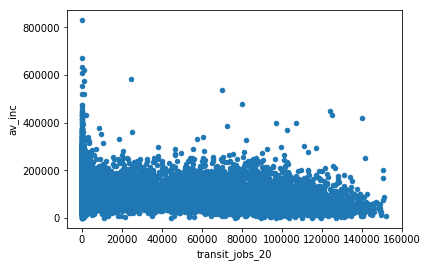

In [67]:
results_transit.plot.scatter(x='transit_jobs_20',y='av_inc')

# Compare accessibility using different networks: walking vs transit

# Pedestrian network

Download the pedestrian network from OSM: This includes all pedestrian accessible pathways including paths and stairways and omits auto only roads such as limited access highways

In [68]:
'''
%%time
h5file = 'osm_walk_2way_subset.h5'
network = pdna.loaders.osm.network_from_bbox(lat_min=37.454539, 
                                                lng_min=-122.342665, 
                                                lat_max=37.905668, 
                                                lng_max=-121.469214, 
                                                network_type='walk', 
                                                two_way=True)
lcn = network.low_connectivity_nodes(10000, 10, imp_name='distance')
network.save_hdf5(data_path+h5file, rm_nodes=lcn)
print 'OSM data save completed:', data_path, h5file
'''

"\n%%time\nh5file = 'osm_walk_2way_subset.h5'\nnetwork = pdna.loaders.osm.network_from_bbox(lat_min=37.454539, \n                                                lng_min=-122.342665, \n                                                lat_max=37.905668, \n                                                lng_max=-121.469214, \n                                                network_type='walk', \n                                                two_way=True)\nlcn = network.low_connectivity_nodes(10000, 10, imp_name='distance')\nnetwork.save_hdf5(data_path+h5file, rm_nodes=lcn)\nprint 'OSM data save completed:', data_path, h5file\n"

Load the pedestrian network, convert edge weight to walking travel time, and calculate the total number of jobs accessible with a 20 min walk. Then combine these results with those of the transit network accessibility metric and compare.

In [70]:
%%time
blocks = pd.read_csv(data_path+'blocks_subset.csv', index_col='block_id')
jobs = pd.read_csv(data_path+'jobs_subset.csv', index_col='job_id')

h5file = 'osm_walk_2way_subset.h5'
osm_walk_nodes = pd.HDFStore(data_path+h5file).nodes
osm_walk_edges = pd.HDFStore(data_path+h5file).edges
print('Loaded',str(len(osm_walk_nodes)),'nodes',str(len(osm_walk_edges)),'edges')

SPEED_MPH = 3
osm_walk_edges['travel_time_min'] = (osm_walk_edges['distance']/1609.34) / SPEED_MPH * 60
print('Converted edge weight')

walk_net = pdna.Network(osm_walk_nodes["x"], 
                   osm_walk_nodes["y"], 
                   osm_walk_edges["from"], 
                   osm_walk_edges["to"],
                   osm_walk_edges[["travel_time_min"]],twoway=True)
print('Network initialized')

blocks['node_id'] = walk_net.get_node_ids(blocks['x'], blocks['y'])
blocks['jobs'] = jobs.groupby(jobs.block_id).size()
walk_net.set(blocks.node_id, variable = blocks.jobs, name='jobs')
walk_jobs_20 = walk_net.aggregate(20, 
                              type='sum', 
                              decay='linear', 
                              name = 'jobs')
print('Aggregation completed')

results_walk = pd.DataFrame({'walk_jobs_20':misc.reindex(walk_jobs_20, blocks.node_id)})
results_combined = results_transit.join(results_walk, how='left', sort=False)
results_combined = results_combined.join(blocks[['x','y']], how='left', sort=False)
results_combined['access_diff'] = results_combined['walk_jobs_20']-results_combined['transit_jobs_20']
results_combined.tail()

Loaded 106165 nodes 153698 edges
Converted edge weight
Network initialized
Removed 18496 rows because they contain missing values
Aggregation completed
CPU times: user 13.9 s, sys: 147 ms, total: 14 s
Wall time: 14 s


## View the difference between the two results on a map

Blue = Transit network provides more access to jobs than pedestrian alone

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a3981a400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a47342ac8>)

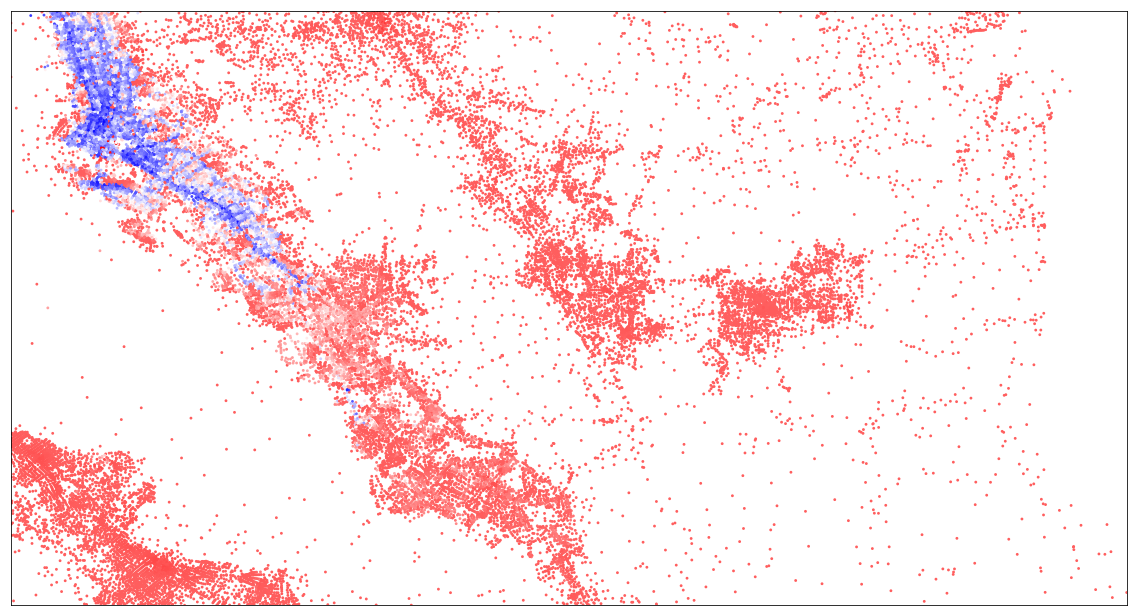

In [71]:
fig, ax = plt.subplots(figsize=[20,14])

bbox = (
    results_combined.y.min(),
    results_combined.x.min(),
    results_combined.y.max(),
    results_combined.x.max())

bmap = Basemap(bbox[1], bbox[0], bbox[3], bbox[2], ax=ax)
x, y = bmap(results_combined.x.values, results_combined.y.values)
plot = bmap.scatter(x, y, c=results_combined.access_diff.values, cmap='bwr',s=8,edgecolor='none')
bmap, fig, ax

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a39da3668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a4bae7518>)

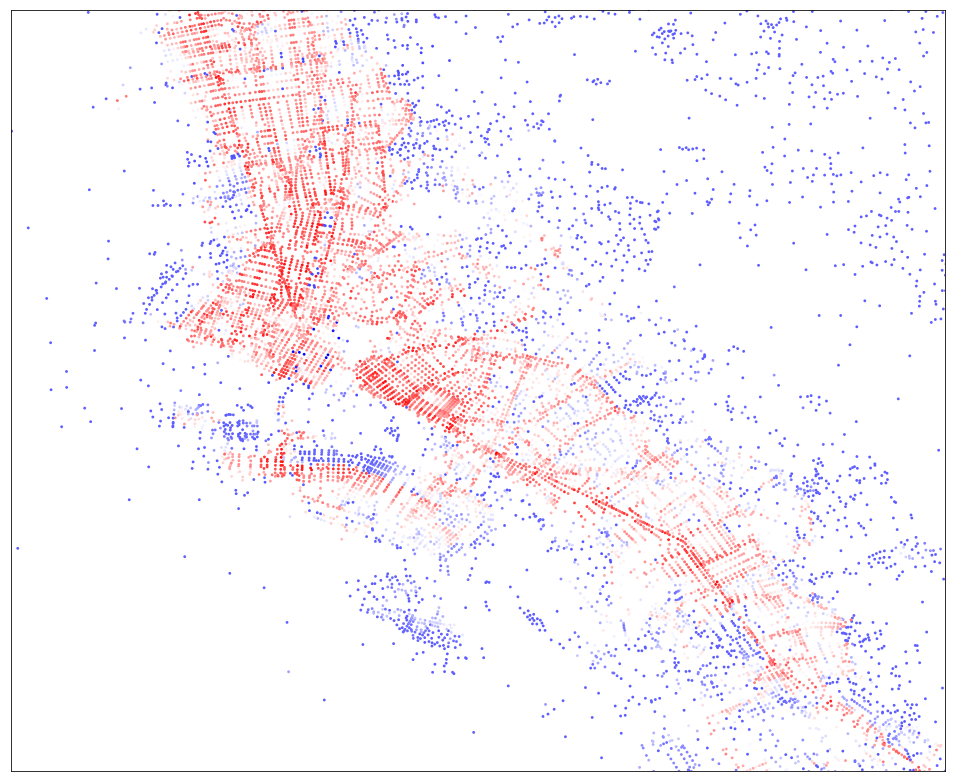

In [72]:
fig, ax = plt.subplots(figsize=[20,14])
bbox = (37.6991981,-122.3426649,37.8847249,-122.1149234) # Oakland

bmap = Basemap(bbox[1], bbox[0], bbox[3], bbox[2], ax=ax)
x, y = bmap(results_combined.x.values, results_combined.y.values)
plot = bmap.scatter(x, y, c=results_combined.access_diff.values, cmap='bwr_r',s=8,edgecolor='none')
bmap, fig, ax